In [2]:
from datahandler import *
from playground import *
from gui import *
from torchutils import *
from models import *
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
minute = True
hour = False

In [5]:
data = None
if minute:
    data = pd.read_csv("BTCUSDT_15m.csv")
    data.drop(["Unnamed: 0", "Close Unix"], axis=1, inplace=True)

elif hour:
    data = pd.read_csv("BTCUSDT_1h.csv")
    data.drop(["Unnamed: 0", "Close Unix"], axis=1, inplace=True)

else:
    if not os.path.exists('./BTCUSDT_DB.csv'):
        data = pd.read_csv("BTCUSDT_1m.csv")
        data = get_dollar_bars(data)
        data.to_csv('./BTCUSDT_DB.csv', sep=',')
    else:
        data = pd.read_csv('./BTCUSDT_DB.csv', sep=',')

handler = NewDataHandler(dataset=data)

In [6]:
crossover_horizon = 3

In [7]:
ma1, ma2, ma_mode = 5, 10, 'normal'
ma_modes = {'exponential': 'EMA', 'normal': 'MA'}
ma_name = ma_modes[ma_mode]
k1, k2 = 5, 10

handler.data = ma_crossover_labelling(handler.data, ma1, ma2, crossover_horizon, ma_mode)

handler.data = add_kendall_tau(handler.data, k1)
handler.data = add_kendall_tau(handler.data, k2)
handler.data = add_ichimoku(handler.data)
ichimoku_cols = ['ABOVE_ICHIMOKU_9', 'ABOVE_ICHIMOKU_26', 'Close_ICHIMOKU_9_PERC_DIFF', 'Close_ICHIMOKU_26_PERC_DIFF']

handler.add_indicators([Indicators.RSI, Indicators.MACD,
                       Indicators.ADX])

handler.create_var_indicator([Indicators.RSI, Indicators.MACD, Indicators.ADX, Indicators.LOG_RET])

# display(handler.data[handler.data.isnull().any(axis=1)]) # Displaying all the rows that contain missing values to see if they are spread across the dataframe

handler.data.replace([np.inf, -np.inf], 0, inplace=True)

# handler.standardize_data()

handler.data.dropna(axis=0, inplace=True)

handler.create_predict_data()

# handler.data.drop('NTrades', axis=1, inplace=True)

predict_data = handler.predict_data
predict_data['Target'] = handler.data['Label']
predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
predict_data[f'{ma_name}{ma1} Var'], predict_data[f'{ma_name}{ma2} Var'] = handler.data[f'{ma_name}{ma1} Var'], handler.data[f'{ma_name}{ma2} Var']
predict_data[f'Close_{ma_name}{ma1}_PERC_DIFF'], predict_data[f'Close_{ma_name}{ma2}_PERC_DIFF'] = handler.data[f'Close_{ma_name}{ma1}_PERC_DIFF'], handler.data[f'Close_{ma_name}{ma2}_PERC_DIFF']
predict_data[f'{ma_name}{ma1} UP'], predict_data[f'{ma_name}{ma2} UP'] = (handler.data[f'{ma_name}{ma1}'] > handler.data[f'{ma_name}{ma2}']) * 1, (handler.data[f'{ma_name}{ma1}'] < handler.data[f'{ma_name}{ma2}']) * 1
predict_data[ichimoku_cols] = handler.data[ichimoku_cols]
predict_data.reset_index(drop=True, inplace=True)

C:\Users\Alexis\AppData\Local\Temp\ipykernel_17152\3885531293.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Target'] = handler.data['Label']
C:\Users\Alexis\AppData\Local\Temp\ipykernel_17152\3885531293.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
C:\Users\Alexis\AppData\Local\Temp\ipykernel_17152\3885531293.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [9]:
standardize_cols = predict_data.drop(['Unix', 'RSI_30-', 'RSI_BTW', 'RSI_70+', 'Target', 'MA5 UP', 'MA10 UP', 'ABOVE_ICHIMOKU_9', 'ABOVE_ICHIMOKU_26'], axis=1).columns

In [11]:
scaler = StandardScaler()
predict_data[standardize_cols] = scaler.fit_transform(predict_data[standardize_cols])

C:\Users\Alexis\AppData\Local\Temp\ipykernel_17152\3159345970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[standardize_cols] = scaler.fit_transform(predict_data[standardize_cols])


In [13]:
handler.data

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades,MA5,MA10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,Label,Kendall_5,Kendall_10,ICHIMOKU_9,ICHIMOKU_26,ABOVE_ICHIMOKU_9,ABOVE_ICHIMOKU_26,Close_ICHIMOKU_9_PERC_DIFF,Close_ICHIMOKU_26_PERC_DIFF,RSI,RSI_30-,RSI_BTW,RSI_70+,MACD,MACD_H,ADX14,+DM,-DM,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,LOG_RET
78,1503012600000,4327.89,4332.26,4314.13,4328.25,10.899352,4.713084e+04,59,4333.718,4336.643,0.000090,-0.000914,0.001263,0.001939,0,-0.4,-0.377778,4366.7025,4370.345,0,0,0.008884,0.009726,48.882487,0,1,0,-2.120408,2.847985,38.787777,12.948911,25.786021,0.001621,0.020591,-0.209500,-0.011171,-0.000886,-0.032114,0.000083
79,1503013500000,4325.82,4332.26,4280.82,4285.08,31.408662,1.349674e+05,89,4320.266,4330.218,-0.003104,-0.001482,0.008211,0.010534,0,-0.4,-0.466667,4366.7025,4370.345,0,0,0.019048,0.019898,40.750486,0,1,0,-5.573522,-0.484104,39.059475,11.791830,29.268193,-0.166358,1.628514,-1.169981,0.007005,0.135041,-0.089357,-0.010024
80,1503014400000,4285.08,4305.76,4267.78,4305.76,10.458487,4.480521e+04,58,4314.058,4325.359,-0.001437,-0.001122,0.001927,0.004552,0,-0.2,-0.422222,4360.2225,4370.345,0,0,0.012649,0.015000,45.433479,0,1,0,-6.565751,-1.181066,39.543175,11.009589,29.604236,0.114919,0.178025,1.439696,0.012384,0.011482,-0.066338,0.004814
81,1503015300000,4309.08,4309.92,4285.85,4292.11,15.912984,6.836449e+04,54,4307.818,4321.215,-0.001446,-0.000958,0.003660,0.006781,0,-0.4,-0.511111,4345.5300,4360.420,0,0,0.012446,0.015915,43.016670,0,1,0,-8.357204,-2.378015,39.793738,11.281316,28.321941,-0.053194,0.272848,1.013448,0.006336,-0.043315,0.024681,-0.003175
82,1503016200000,4292.11,4309.15,4286.01,4302.15,12.542524,5.393592e+04,58,4302.670,4317.998,-0.001195,-0.000744,0.000121,0.003684,0,-0.2,-0.511111,4319.3975,4352.035,0,0,0.004009,0.011595,45.320634,0,1,0,-8.864613,-2.308340,40.026180,10.797128,27.106378,0.053560,0.060715,-0.029300,0.005841,-0.042919,-0.042919,0.002336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193435,1677537900000,23397.31,23557.79,23390.54,23482.13,3276.986710,7.697566e+07,118924,23405.900,23366.460,0.000866,0.000960,-0.003246,-0.004926,0,0.6,0.866667,23546.6300,23546.630,0,0,0.002747,0.002747,61.932773,0,1,0,0.601898,25.433536,24.975911,27.116201,18.390167,0.147908,-1.057597,0.226309,-0.017551,-0.127108,0.434192,0.003619
193436,1677538800000,23481.28,23508.27,23448.20,23467.31,2209.161100,5.187482e+07,84221,23423.086,23388.653,0.000734,0.000950,-0.001884,-0.003352,0,0.6,0.822222,23528.6600,23528.660,0,0,0.002614,0.002614,59.976988,0,1,0,8.071806,26.322756,24.561590,25.845527,17.528397,-0.031579,12.410594,0.034962,-0.016589,-0.046860,-0.046860,-0.000631
193437,1677539700000,23467.89,23525.88,23466.17,23490.51,1624.076700,3.816044e+07,74878,23443.360,23405.567,0.000866,0.000723,-0.002007,-0.003616,0,0.8,0.822222,23528.6600,23528.660,0,0,0.001624,0.001624,62.000045,0,1,0,15.683025,27.147179,24.367283,26.019732,16.691128,0.033731,0.942939,0.031320,-0.007911,-0.047766,0.006740,0.000988
193438,1677540600000,23491.18,23555.24,23480.79,23534.67,1677.606430,3.944878e+07,81570,23474.386,23425.349,0.001323,0.000845,-0.002561,-0.004645,0,0.8,0.822222,23528.6600,23528.660,1,1,-0.000255,-0.000255,65.567754,0,1,0,24.990241,29.163517,24.498989,26.828370,15.685094,0.057544,0.593458,0.074274,0.005405,-0.060274,0.031078,0.001878


In [14]:
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,RSI_30-,RSI_BTW,RSI_70+,LOG_RET,Target,Kendall_5,Kendall_10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,MA5 UP,MA10 UP,ABOVE_ICHIMOKU_9,ABOVE_ICHIMOKU_26,Close_ICHIMOKU_9_PERC_DIFF,Close_ICHIMOKU_26_PERC_DIFF
0,1503012600000,-0.035522,-0.001473,-0.000773,-0.253072,-0.062919,-0.252425,0,1,0,0.016056,0,-0.720177,-0.802778,0.039862,-0.674455,0.253221,0.258330,0,1,0,0,0.419545,0.414651
1,1503013500000,-1.600967,0.016054,-0.014394,0.120275,0.715414,-0.595127,0,1,0,-2.164231,0,-0.720177,-0.982611,-1.557691,-1.088708,1.649389,1.406335,0,1,0,0,0.872535,0.805223
2,1503014400000,1.020331,0.000244,0.022617,0.230765,0.007901,-0.457312,0,1,0,1.036659,0,-0.372902,-0.892694,-0.723989,-0.826282,0.386621,0.607313,0,1,0,0,0.587329,0.617147
3,1503015300000,-0.546363,0.001277,0.016571,0.106548,-0.305867,0.087593,0,1,0,-0.686827,0,-0.720177,-1.072528,-0.728733,-0.706516,0.734772,0.905077,0,1,0,0,0.578297,0.652301
4,1503016200000,0.448510,-0.001035,0.001783,0.096374,-0.303605,-0.317114,0,1,0,0.502119,0,-0.372902,-1.072528,-0.603010,-0.550567,0.023647,0.491362,0,1,0,0,0.202274,0.486439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193349,1677537900000,1.327770,-0.013225,0.005408,-0.384131,-0.785676,2.539235,0,1,0,0.778709,0,1.016200,1.714886,0.427920,0.693704,-0.652974,-0.658643,1,0,0,0,0.146017,0.146697
193350,1677538800000,-0.344924,0.133583,0.002694,-0.364360,-0.326170,-0.340707,0,1,0,-0.138072,0,1.016200,1.624969,0.361823,0.686377,-0.379324,-0.448386,1,0,0,0,0.140112,0.141610
193351,1677539700000,0.263716,0.008581,0.002643,-0.186109,-0.331359,-0.019813,0,1,0,0.211265,0,1.363476,1.624969,0.427484,0.520933,-0.403980,-0.483688,1,0,0,0,0.095980,0.103590
193352,1677540600000,0.485637,0.004772,0.003252,0.087416,-0.402976,0.125890,0,1,0,0.403256,0,1.363476,1.624969,0.656472,0.610012,-0.515366,-0.621140,1,0,1,1,0.012217,0.031430


In [15]:
handler.data['LOG_RET'].abs().describe()

count    193354.000000
mean          0.002662
std           0.003795
min           0.000000
25%           0.000682
50%           0.001564
75%           0.003187
max           0.203992
Name: LOG_RET, dtype: float64

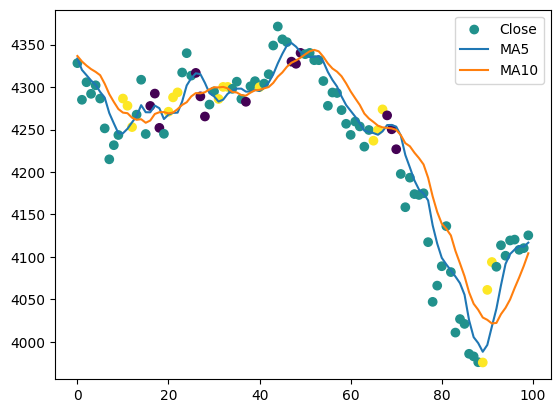

In [16]:
plt.scatter(range(100), handler.data['Close'][0:100], c=handler.data['Label'][0:100], label="Close")
plt.plot(range(100), handler.data[f'{ma_name}{ma1}'][0:100], label=f"{ma_name}{ma1}")
plt.plot(range(100), handler.data[f'{ma_name}{ma2}'][0:100], label=f"{ma_name}{ma2}")
plt.legend()
plt.show()

In [17]:
handler.data

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades,MA5,MA10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,Label,Kendall_5,Kendall_10,ICHIMOKU_9,ICHIMOKU_26,ABOVE_ICHIMOKU_9,ABOVE_ICHIMOKU_26,Close_ICHIMOKU_9_PERC_DIFF,Close_ICHIMOKU_26_PERC_DIFF,RSI,RSI_30-,RSI_BTW,RSI_70+,MACD,MACD_H,ADX14,+DM,-DM,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,LOG_RET
78,1503012600000,4327.89,4332.26,4314.13,4328.25,10.899352,4.713084e+04,59,4333.718,4336.643,0.000090,-0.000914,0.001263,0.001939,0,-0.4,-0.377778,4366.7025,4370.345,0,0,0.008884,0.009726,48.882487,0,1,0,-2.120408,2.847985,38.787777,12.948911,25.786021,0.001621,0.020591,-0.209500,-0.011171,-0.000886,-0.032114,0.000083
79,1503013500000,4325.82,4332.26,4280.82,4285.08,31.408662,1.349674e+05,89,4320.266,4330.218,-0.003104,-0.001482,0.008211,0.010534,0,-0.4,-0.466667,4366.7025,4370.345,0,0,0.019048,0.019898,40.750486,0,1,0,-5.573522,-0.484104,39.059475,11.791830,29.268193,-0.166358,1.628514,-1.169981,0.007005,0.135041,-0.089357,-0.010024
80,1503014400000,4285.08,4305.76,4267.78,4305.76,10.458487,4.480521e+04,58,4314.058,4325.359,-0.001437,-0.001122,0.001927,0.004552,0,-0.2,-0.422222,4360.2225,4370.345,0,0,0.012649,0.015000,45.433479,0,1,0,-6.565751,-1.181066,39.543175,11.009589,29.604236,0.114919,0.178025,1.439696,0.012384,0.011482,-0.066338,0.004814
81,1503015300000,4309.08,4309.92,4285.85,4292.11,15.912984,6.836449e+04,54,4307.818,4321.215,-0.001446,-0.000958,0.003660,0.006781,0,-0.4,-0.511111,4345.5300,4360.420,0,0,0.012446,0.015915,43.016670,0,1,0,-8.357204,-2.378015,39.793738,11.281316,28.321941,-0.053194,0.272848,1.013448,0.006336,-0.043315,0.024681,-0.003175
82,1503016200000,4292.11,4309.15,4286.01,4302.15,12.542524,5.393592e+04,58,4302.670,4317.998,-0.001195,-0.000744,0.000121,0.003684,0,-0.2,-0.511111,4319.3975,4352.035,0,0,0.004009,0.011595,45.320634,0,1,0,-8.864613,-2.308340,40.026180,10.797128,27.106378,0.053560,0.060715,-0.029300,0.005841,-0.042919,-0.042919,0.002336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193435,1677537900000,23397.31,23557.79,23390.54,23482.13,3276.986710,7.697566e+07,118924,23405.900,23366.460,0.000866,0.000960,-0.003246,-0.004926,0,0.6,0.866667,23546.6300,23546.630,0,0,0.002747,0.002747,61.932773,0,1,0,0.601898,25.433536,24.975911,27.116201,18.390167,0.147908,-1.057597,0.226309,-0.017551,-0.127108,0.434192,0.003619
193436,1677538800000,23481.28,23508.27,23448.20,23467.31,2209.161100,5.187482e+07,84221,23423.086,23388.653,0.000734,0.000950,-0.001884,-0.003352,0,0.6,0.822222,23528.6600,23528.660,0,0,0.002614,0.002614,59.976988,0,1,0,8.071806,26.322756,24.561590,25.845527,17.528397,-0.031579,12.410594,0.034962,-0.016589,-0.046860,-0.046860,-0.000631
193437,1677539700000,23467.89,23525.88,23466.17,23490.51,1624.076700,3.816044e+07,74878,23443.360,23405.567,0.000866,0.000723,-0.002007,-0.003616,0,0.8,0.822222,23528.6600,23528.660,0,0,0.001624,0.001624,62.000045,0,1,0,15.683025,27.147179,24.367283,26.019732,16.691128,0.033731,0.942939,0.031320,-0.007911,-0.047766,0.006740,0.000988
193438,1677540600000,23491.18,23555.24,23480.79,23534.67,1677.606430,3.944878e+07,81570,23474.386,23425.349,0.001323,0.000845,-0.002561,-0.004645,0,0.8,0.822222,23528.6600,23528.660,1,1,-0.000255,-0.000255,65.567754,0,1,0,24.990241,29.163517,24.498989,26.828370,15.685094,0.057544,0.593458,0.074274,0.005405,-0.060274,0.031078,0.001878


In [18]:
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,RSI_30-,RSI_BTW,RSI_70+,LOG_RET,Target,Kendall_5,Kendall_10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,MA5 UP,MA10 UP,ABOVE_ICHIMOKU_9,ABOVE_ICHIMOKU_26,Close_ICHIMOKU_9_PERC_DIFF,Close_ICHIMOKU_26_PERC_DIFF
0,1503012600000,-0.035522,-0.001473,-0.000773,-0.253072,-0.062919,-0.252425,0,1,0,0.016056,0,-0.720177,-0.802778,0.039862,-0.674455,0.253221,0.258330,0,1,0,0,0.419545,0.414651
1,1503013500000,-1.600967,0.016054,-0.014394,0.120275,0.715414,-0.595127,0,1,0,-2.164231,0,-0.720177,-0.982611,-1.557691,-1.088708,1.649389,1.406335,0,1,0,0,0.872535,0.805223
2,1503014400000,1.020331,0.000244,0.022617,0.230765,0.007901,-0.457312,0,1,0,1.036659,0,-0.372902,-0.892694,-0.723989,-0.826282,0.386621,0.607313,0,1,0,0,0.587329,0.617147
3,1503015300000,-0.546363,0.001277,0.016571,0.106548,-0.305867,0.087593,0,1,0,-0.686827,0,-0.720177,-1.072528,-0.728733,-0.706516,0.734772,0.905077,0,1,0,0,0.578297,0.652301
4,1503016200000,0.448510,-0.001035,0.001783,0.096374,-0.303605,-0.317114,0,1,0,0.502119,0,-0.372902,-1.072528,-0.603010,-0.550567,0.023647,0.491362,0,1,0,0,0.202274,0.486439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193349,1677537900000,1.327770,-0.013225,0.005408,-0.384131,-0.785676,2.539235,0,1,0,0.778709,0,1.016200,1.714886,0.427920,0.693704,-0.652974,-0.658643,1,0,0,0,0.146017,0.146697
193350,1677538800000,-0.344924,0.133583,0.002694,-0.364360,-0.326170,-0.340707,0,1,0,-0.138072,0,1.016200,1.624969,0.361823,0.686377,-0.379324,-0.448386,1,0,0,0,0.140112,0.141610
193351,1677539700000,0.263716,0.008581,0.002643,-0.186109,-0.331359,-0.019813,0,1,0,0.211265,0,1.363476,1.624969,0.427484,0.520933,-0.403980,-0.483688,1,0,0,0,0.095980,0.103590
193352,1677540600000,0.485637,0.004772,0.003252,0.087416,-0.402976,0.125890,0,1,0,0.403256,0,1.363476,1.624969,0.656472,0.610012,-0.515366,-0.621140,1,0,1,1,0.012217,0.031430


In [19]:
seq_length = 15
dataset = TSDataset(predict_data, seq_length)

In [20]:
train_indices = range(0, round(0.7 * len(dataset)), int(seq_length))
val_indices = range(round(0.7 * len(dataset)), round(0.9 * len(dataset)), int(seq_length))
test_indices = range(round(0.9 * len(dataset)), len(dataset) - seq_length)

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices) # Validation set will be training set for Meta Labelling
test_set = torch.utils.data.Subset(dataset, test_indices)

In [21]:
print(train_indices)
print(val_indices)
print(test_indices)

range(0, 135337, 15)
range(135337, 174005, 15)
range(174005, 193324)


In [22]:
label_distribution = (predict_data.loc[train_set.indices, 'Target'].value_counts() / predict_data.loc[train_set.indices, 'Target'].shape[0]).sort_index().to_list()
display(predict_data.loc[train_set.indices, 'Target'].value_counts())
label_distribution

Target
 0    6161
 1    1433
-1    1429
Name: count, dtype: int64

[0.1583730466585393, 0.6828105951457387, 0.15881635819572204]

In [23]:
class_weights = [1 / p for p in label_distribution]
print(class_weights)
weights = [class_weights[torch.argmax(label)] for _, label in train_set]
train_sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_set), replacement=True)
# train_sampler = None

[6.314205738278516, 1.4645349780879726, 6.296580600139568]


In [24]:
input_size = dataset.size
hidden_size = 500
batch_size = 16
dynamic_batch = False
num_layers = 2
output_size = predict_data['Target'].unique().size
lstm_model = LSTMModel(input_size, hidden_size,
                       num_layers, output_size).to(device)

In [37]:
weights = torch.Tensor(label_distribution).to(device)
losses, accuracies, val_losses, val_accuracies, _, _ = train_lstm(lstm_model, train_set, val_set, 10, 0.000001,
           batch_size, num_layers, hidden_size, device, train_sampler, class_weights=None, model_name=f'crossover_{seq_length}_to_{crossover_horizon}', save=True, dynamic_batch=False)

Epoch: 1/10 -- [8460/9023 (100.0%)]	Loss: 0.6922983158353373	Accuracy: 0.859	Time taken: 85.671875	Validation Loss: 0.7496048808097839 || Validation Accuracy: 0.795
Epoch: 2/10 -- [8460/9023 (100.0%)]	Loss: 0.6888955511311268	Accuracy: 0.865	Time taken: 85.40625	Validation Loss: 0.7510139346122742 || Validation Accuracy: 0.792
Epoch: 3/10 -- [8460/9023 (100.0%)]	Loss: 0.6959419357227096	Accuracy: 0.858	Time taken: 86.53125	Validation Loss: 0.7542533278465271 || Validation Accuracy: 0.787
Epoch: 4/10 -- [8460/9023 (100.0%)]	Loss: 0.6869239870538103	Accuracy: 0.867	Time taken: 85.28125	Validation Loss: 0.7557336688041687 || Validation Accuracy: 0.786
Epoch: 5/10 -- [8460/9023 (100.0%)]	Loss: 0.6877015321812732	Accuracy: 0.867	Time taken: 85.15625	Validation Loss: 0.7520883083343506 || Validation Accuracy: 0.791
Epoch: 6/10 -- [8460/9023 (100.0%)]	Loss: 0.6894851052169259	Accuracy: 0.864	Time taken: 84.890625	Validation Loss: 0.7543928027153015 || Validation Accuracy: 0.787
Epoch: 7/10 --

In [36]:
# lstm_model = torch.load(f'./models/crossover_{seq_length}_to_{crossover_horizon}.pt').to(device)

In [39]:
eval_lstm(lstm_model, test_set, 64, num_layers, hidden_size, device)

Accuracy : 0.7731766654588746 || Loss : 0.7742576599121094
Confusion matrix : 
[[2.722e+03 2.980e+02 1.100e+01]
 [1.851e+03 9.435e+03 1.971e+03]
 [5.000e+00 2.460e+02 2.780e+03]]


(tensor([[9.9990e-01, 9.7859e-05, 1.7888e-07],
         [4.9188e-01, 2.3491e-01, 2.7321e-01],
         [2.4188e-05, 3.2793e-03, 9.9670e-01],
         ...,
         [3.6837e-07, 1.2337e-04, 9.9988e-01],
         [6.3142e-01, 2.1831e-01, 1.5027e-01],
         [9.9876e-01, 1.2235e-03, 1.3229e-05]], device='cuda:0',
        grad_fn=<CatBackward0>),
 tensor([[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         ...,
         [0., 0., 1.],
         [1., 0., 0.],
         [1., 0., 0.]], device='cuda:0'))

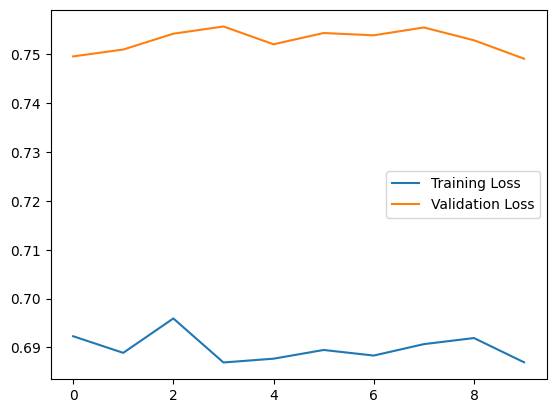

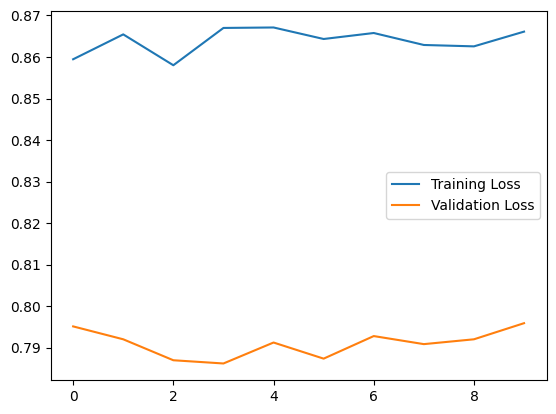

In [38]:
plt.plot([float(loss) for loss in losses], label="Training Loss")
plt.plot([float(loss) for loss in val_losses], label="Validation Loss")
plt.legend()
plt.show()
plt.plot([float(acc) for acc in accuracies], label="Training Loss")
plt.plot([float(acc) for acc in val_accuracies], label="Validation Loss")
plt.legend()
plt.show()